In [1]:
import pandas as pd
import numpy as np
import json
import glob
import pandas as pd
import csv

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy
import spacy
from nltk.corpus import stopwords


In [2]:
# Bag of words for each category to classify text

topics = {"fee": ["fee", "money", "price", "cost", "expensive", "cost", "charge"],
        "transaction": ["deposit", "withdraw", "bank", "delay", "debit", "credit", "card"], #! Check if these words are lemmas.
        "trust": ["company", "scam", "fraud", "theft"], 
        "service": ["service", "customer", "contact", "support", "email"],
        "app": ["interface", "easy", "clean", "user" ,"issue", "bug", "glitch", "ui"],
        "verification": ["registration", "verification", "document", "license", "photo", "identification"]}

        # A combination of Knn with TF-IDF and LDA with TF-IDF were used to determine the topics adn keywords for each topic

In [3]:
# Pre-processing the document
all_files = ["coinbase.csv", "binance.csv", "ftx.csv", "kraken.csv"]

# Combine all the csv files into one
li = []
for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

# Get only rows with >50 chars or about 10 words
def get_rows(row):
    row["review_len"] = len(row["content"])
    return row;
    
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.loc[:, ["reviewId", "content", "score", "at"]]
frame = frame.apply(get_rows, axis=1)
frame = frame.loc[frame["review_len"] > 50]
frame


,reviewId,content,score,at,review_len
2,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,154
3,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,485
4,c592afe5-b785-49f7-a760-c663f516d303,Was liking it all the way up til the part wher...,1,2022-07-01 08:56:03,109
5,4d1e73a6-5209-4e16-bfd2-008da201c5c5,Not your keys not your crypto. They're also se...,1,2022-07-01 08:48:22,78
8,d1dd5332-fc37-40bd-a499-d23af117acf7,You guys should create another payment mood ap...,3,2022-07-01 07:12:55,66
...,...,...,...,...,...
19877,ffac6965-3de9-4d5b-9c36-5426d925dd12,Slick design and easy to use. Still have to us...,5,2020-11-17 19:11:44,125
19878,5d11a98a-6989-4244-85f2-be72ac295040,"Clean, simple to use app, PLEASE PUT A FIELD W...",5,2020-11-17 18:57:57,244
19879,e6a22ec1-d0ca-455a-b2aa-28b799fc0972,"Unbelievable. This is by far the most easy, us...",5,2020-11-17 18:31:37,116
19880,2ba1ad26-be94-462a-a5df-8d62224abe73,No crypto deposit/withdraw options. Useless. H...,1,2020-11-16 13:30:54,110


In [4]:
# Break each review into sentences
sentenced_reviews = {"reviewId": [], "content": [], "score": [], "at" : [], "review_len": [], "sentence_len": []}
frame["sentences"] = frame["content"].str.split(".");

for index, row in frame.iterrows():    
    for sentence in row["sentences"]:
        sentenced_reviews["content"].append(sentence)
        sentenced_reviews["reviewId"].append(row["reviewId"])
        sentenced_reviews["score"].append(row["score"])
        sentenced_reviews["review_len"].append(row["review_len"])
        sentenced_reviews["at"].append(row["at"])
        sentenced_reviews["sentence_len"].append(len(sentence))

frame = pd.DataFrame(sentenced_reviews)
frame = frame.loc[(frame["content"].str.len() > 20)] # Only get sentences longer than about 5 words

In [5]:
frame

,reviewId,content,score,at,review_len,sentence_len
0,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,154,58
2,40e56de6-c266-446a-89a6-5191a72324e8,it takes to much time to look around to invest,4,2022-07-01 10:07:37,154,46
4,40e56de6-c266-446a-89a6-5191a72324e8,I like when you had gainers and losers format,4,2022-07-01 10:07:37,154,46
5,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,485,153
6,7bbae22c-e255-478e-aa79-078104b23046,Customer service said there was nothing they ...,1,2022-07-01 09:11:51,485,102
...,...,...,...,...,...,...
32310,ec4bae64-7537-4654-a08b-28f5f3f2f925,I can fund my account both wire & debit/credi...,5,2020-10-07 18:40:35,478,64
32311,ec4bae64-7537-4654-a08b-28f5f3f2f925,I have access to all crypto,5,2020-10-07 18:40:35,478,28
32312,ec4bae64-7537-4654-a08b-28f5f3f2f925,"Login is as usual, so far no problem using my...",5,2020-10-07 18:40:35,478,67
32313,ec4bae64-7537-4654-a08b-28f5f3f2f925,I believe this was intended for your average ...,5,2020-10-07 18:40:35,478,144


In [6]:
# Process documents and insert to df

spacy.load
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
allowed_postags=["NOUN", "ADJ"]
stop_words=stopwords.words("english")
def insert_processed_doc(row):

    # Lemmatization
    text = row["content"]
    doc = nlp(text) # Create document from the raw text/string
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags and token.pos_ not in stop_words:
            new_text.append(token.lemma_) # Appends only lemma to new_text
    lemma = " ".join(new_text)
 
    # Remove marks and make everything lowercase
    final_doc = gensim.utils.simple_preprocess(lemma, deacc=True);

    row["content_proc"] = final_doc
    return row

frame = frame.apply(insert_processed_doc, axis=1)

frame


,reviewId,content,score,at,review_len,sentence_len,content_proc
0,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,154,58,"[need, old, format]"
2,40e56de6-c266-446a-89a6-5191a72324e8,it takes to much time to look around to invest,4,2022-07-01 10:07:37,154,46,"[much, time]"
4,40e56de6-c266-446a-89a6-5191a72324e8,I like when you had gainers and losers format,4,2022-07-01 10:07:37,154,46,"[gainer, loser]"
5,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,485,153,"[problem, money, crypto, suspicious]"
6,7bbae22c-e255-478e-aa79-078104b23046,Customer service said there was nothing they ...,1,2022-07-01 09:11:51,485,102,"[service, flat, problem]"
...,...,...,...,...,...,...,...
32310,ec4bae64-7537-4654-a08b-28f5f3f2f925,I can fund my account both wire & debit/credi...,5,2020-10-07 18:40:35,478,64,"[account, wire, debit, credit, card]"
32311,ec4bae64-7537-4654-a08b-28f5f3f2f925,I have access to all crypto,5,2020-10-07 18:40:35,478,28,"[access, crypto]"
32312,ec4bae64-7537-4654-a08b-28f5f3f2f925,"Login is as usual, so far no problem using my...",5,2020-10-07 18:40:35,478,67,"[usual, problem, authenticator]"
32313,ec4bae64-7537-4654-a08b-28f5f3f2f925,I believe this was intended for your average ...,5,2020-10-07 18:40:35,478,144,"[average, advanced, trading, form, available, ..."


In [7]:
# Returns the topic which the processed_doc contains the most words from
def get_topic(topics, processed_doc):
    topic_scores = dict.fromkeys(topics, 0)
    for word in processed_doc:
        for topic in topics.keys():
            if word in topics[topic]: topic_scores[topic] += 1
    topic_max = max(topic_scores, key=topic_scores.get)  
    if topic_scores[topic_max] == 0: topic_max = "N"     
    return (topic_max, topic_scores[topic_max] if topic_max != "N" else 0)

In [8]:
def insert_topic(row):
    topic_max, topic_score = get_topic(topics, row["content_proc"])
    row["topic"] = topic_max
    row["topic_score"] = topic_score
    return row

frame = frame.apply(insert_topic, axis=1)

In [9]:
frame.loc[frame["topic"] != "N"]

,reviewId,content,score,at,review_len,sentence_len,content_proc,topic,topic_score
5,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,485,153,"[problem, money, crypto, suspicious]",fee,1
6,7bbae22c-e255-478e-aa79-078104b23046,Customer service said there was nothing they ...,1,2022-07-01 09:11:51,485,102,"[service, flat, problem]",service,1
7,7bbae22c-e255-478e-aa79-078104b23046,"So to summarize, they have no problem taking ...",1,2022-07-01 09:11:51,485,91,"[problem, money, access]",fee,1
8,7bbae22c-e255-478e-aa79-078104b23046,"I'm not the smartest guy, but isn't that a fo...",1,2022-07-01 09:11:51,485,135,"[smart, guy, form, theft, good, luck, clown]",trust,1
17,d1dd5332-fc37-40bd-a499-d23af117acf7,You guys should create another payment mood ap...,3,2022-07-01 07:12:55,66,66,"[guy, payment, mood, debit, card]",transaction,2
...,...,...,...,...,...,...,...,...,...
32300,e6a22ec1-d0ca-455a-b2aa-28b799fc0972,"This is by far the most easy, user friendly i...",5,2020-11-17 18:31:37,116,58,"[easy, user, friendly, interface, app]",app,3
32305,2ba1ad26-be94-462a-a5df-8d62224abe73,No crypto deposit/withdraw options,1,2020-11-16 13:30:54,110,34,"[crypto, deposit, option]",transaction,1
32309,ec4bae64-7537-4654-a08b-28f5f3f2f925,"Finally, a satisfying user friendly, clean & s...",5,2020-10-07 18:40:35,478,88,"[user, friendly, clean, simple, way, track, cr...",app,2
32310,ec4bae64-7537-4654-a08b-28f5f3f2f925,I can fund my account both wire & debit/credi...,5,2020-10-07 18:40:35,478,64,"[account, wire, debit, credit, card]",transaction,3


In [10]:
frame["topic"].value_counts()

N               14579
fee              1860
app              1527
service          1263
transaction       706
verification      317
trust             290
Name: topic, dtype: int64

In [11]:
# Make predictions on sentiment
from textblob import TextBlob

def add_sentiment_cols(row):
    sent_obj = TextBlob(row["content"])
    row["sent_pol"] = sent_obj.sentiment.polarity
    row["sent_sub"] = sent_obj.sentiment.subjectivity
    return row;

frame = frame.apply(add_sentiment_cols, axis="columns")
frame

,reviewId,content,score,at,review_len,sentence_len,content_proc,topic,topic_score,sent_pol,sent_sub
0,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,154,58,"[need, old, format]",N,0,0.050000,0.100000
2,40e56de6-c266-446a-89a6-5191a72324e8,it takes to much time to look around to invest,4,2022-07-01 10:07:37,154,46,"[much, time]",N,0,0.200000,0.200000
4,40e56de6-c266-446a-89a6-5191a72324e8,I like when you had gainers and losers format,4,2022-07-01 10:07:37,154,46,"[gainer, loser]",N,0,-0.200000,0.200000
5,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,485,153,"[problem, money, crypto, suspicious]",fee,1,0.000000,0.000000
6,7bbae22c-e255-478e-aa79-078104b23046,Customer service said there was nothing they ...,1,2022-07-01 09:11:51,485,102,"[service, flat, problem]",service,1,-0.025000,0.125000
...,...,...,...,...,...,...,...,...,...,...,...
32310,ec4bae64-7537-4654-a08b-28f5f3f2f925,I can fund my account both wire & debit/credi...,5,2020-10-07 18:40:35,478,64,"[account, wire, debit, credit, card]",transaction,3,0.000000,0.000000
32311,ec4bae64-7537-4654-a08b-28f5f3f2f925,I have access to all crypto,5,2020-10-07 18:40:35,478,28,"[access, crypto]",N,0,0.000000,0.000000
32312,ec4bae64-7537-4654-a08b-28f5f3f2f925,"Login is as usual, so far no problem using my...",5,2020-10-07 18:40:35,478,67,"[usual, problem, authenticator]",N,0,-0.075000,0.625000
32313,ec4bae64-7537-4654-a08b-28f5f3f2f925,I believe this was intended for your average ...,5,2020-10-07 18:40:35,478,144,"[average, advanced, trading, form, available, ...",N,0,0.178571,0.557143


In [12]:
frame.loc[frame["topic"] == "N"]

,reviewId,content,score,at,review_len,sentence_len,content_proc,topic,topic_score,sent_pol,sent_sub
0,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,154,58,"[need, old, format]",N,0,0.050000,0.100000
2,40e56de6-c266-446a-89a6-5191a72324e8,it takes to much time to look around to invest,4,2022-07-01 10:07:37,154,46,"[much, time]",N,0,0.200000,0.200000
4,40e56de6-c266-446a-89a6-5191a72324e8,I like when you had gainers and losers format,4,2022-07-01 10:07:37,154,46,"[gainer, loser]",N,0,-0.200000,0.200000
10,c592afe5-b785-49f7-a760-c663f516d303,Was liking it all the way up til the part wher...,1,2022-07-01 08:56:03,109,97,"[way, part, info, ice]",N,0,0.000000,0.000000
14,4d1e73a6-5209-4e16-bfd2-008da201c5c5,Not your keys not your crypto,1,2022-07-01 08:48:22,78,29,"[key, crypto]",N,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
32295,ffac6965-3de9-4d5b-9c36-5426d925dd12,"Still have to use the more advanced features,...",5,2020-11-17 19:11:44,125,95,"[advanced, feature, quick, glance, fund, perfect]",N,0,0.558333,0.650000
32308,2ba1ad26-be94-462a-a5df-8d62224abe73,What's the point of having a half baked app?,1,2020-11-16 13:30:54,110,45,"[point, half, baked, app]",N,0,-0.166667,0.166667
32311,ec4bae64-7537-4654-a08b-28f5f3f2f925,I have access to all crypto,5,2020-10-07 18:40:35,478,28,"[access, crypto]",N,0,0.000000,0.000000
32312,ec4bae64-7537-4654-a08b-28f5f3f2f925,"Login is as usual, so far no problem using my...",5,2020-10-07 18:40:35,478,67,"[usual, problem, authenticator]",N,0,-0.075000,0.625000


In [13]:
frame.loc[frame["topic"] == "verification"]

,reviewId,content,score,at,review_len,sentence_len,content_proc,topic,topic_score,sent_pol,sent_sub
56,5c37d628-d820-48cb-9bab-eca3cc93f6b8,It won't eve accept my driver's license even t...,2,2022-07-01 02:21:00,146,146,"[driver, license, clear, picture, few, month]",verification,1,-0.05,0.241667
230,02f8fdd7-b89e-491c-942b-69d9f442ce15,You give photo id settings for an A4 document,2,2022-06-29 16:47:45,478,46,"[photo, setting, document]",verification,2,0.00,0.000000
273,591887c7-ef72-43d6-8e7a-d8dfb4cec0f2,It wont allow me to verify my drivers license ...,1,2022-06-29 02:14:52,195,62,"[driver, license]",verification,1,0.00,0.000000
344,3e1fdc1f-41b0-45cc-b68a-e914b8c305c0,My identification verification keeps failing a...,1,2022-06-28 13:07:46,142,66,"[identification, verification]",verification,2,-0.40,0.800000
486,37dda3b4-d227-4f52-8f11-fcaf5e547806,I don't receive text messages for the 2-step v...,1,2022-06-26 21:27:15,158,96,"[text, message, step, verification, method, app]",verification,1,0.00,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
32070,97417652-aa60-4711-8acb-d627bbc9cd97,"In the ""documents"" section, my documents don'...",1,2021-01-30 05:32:07,498,54,"[document, section, document]",verification,2,0.00,0.000000
32084,bec17297-510f-48c4-9588-fd9b54ed5f93,"Then I need to do verification, done and wait...",1,2021-01-30 02:13:04,249,97,"[verification, whole, day]",verification,1,0.20,0.400000
32108,667fd1fb-9f5f-4acf-acb7-4797ac094024,Worst app ever! I've never taken the time to ...,1,2021-01-29 14:59:11,191,153,"[bad, app, time, app, verification, process]",verification,1,-1.00,1.000000
32129,4170d3aa-ed05-4189-bf66-7df07f9a9b64,"Will not let me sign into account, registratio...",1,2021-01-25 03:49:44,79,78,"[account, registration, code]",verification,1,0.00,0.000000


In [14]:
# Create new DF to store whether sentiment is positive
sentiment_df = frame.copy()
sentiment_df.reset_index(inplace=True)
sentiment_df.drop(columns="index", inplace=True)
sentiment_df["is_positive"] = sentiment_df["sent_pol"] > 0
sentiment_df.head(100)

,reviewId,content,score,at,review_len,sentence_len,content_proc,topic,topic_score,sent_pol,sent_sub,is_positive
0,40e56de6-c266-446a-89a6-5191a72324e8,Don't like to do update needs to go back to th...,4,2022-07-01 10:07:37,154,58,"[need, old, format]",N,0,0.050000,0.100000,True
1,40e56de6-c266-446a-89a6-5191a72324e8,it takes to much time to look around to invest,4,2022-07-01 10:07:37,154,46,"[much, time]",N,0,0.200000,0.200000,True
2,40e56de6-c266-446a-89a6-5191a72324e8,I like when you had gainers and losers format,4,2022-07-01 10:07:37,154,46,"[gainer, loser]",N,0,-0.200000,0.200000,False
3,7bbae22c-e255-478e-aa79-078104b23046,DO NOT RECOMMEND - They have no problem taking...,1,2022-07-01 09:11:51,485,153,"[problem, money, crypto, suspicious]",fee,1,0.000000,0.000000,False
4,7bbae22c-e255-478e-aa79-078104b23046,Customer service said there was nothing they ...,1,2022-07-01 09:11:51,485,102,"[service, flat, problem]",service,1,-0.025000,0.125000,False
...,...,...,...,...,...,...,...,...,...,...,...,...
95,b9b1afdc-3901-492c-8cfa-4bd677b7cabf,If this company works for your situation grea...,1,2022-06-30 11:45:39,494,170,"[company, situation, great, honest, opinion, o...",trust,1,0.327083,0.797917,True
96,6a386383-f831-419e-9b42-79f74b6b6d54,This app isn't working So bad After much trial...,1,2022-06-30 11:31:06,55,55,"[app, bad, much, trial, fake]",N,0,-0.333333,0.622222,False
97,5b5c2172-921b-4b33-99a5-303941703c57,Terrible first time experience,1,2022-06-30 11:02:11,341,30,"[terrible, first, time, experience]",N,0,-0.375000,0.666667,False
98,5b5c2172-921b-4b33-99a5-303941703c57,After I completed verification I called custo...,1,2022-06-30 11:02:11,341,148,"[verification, customer, service, representati...",service,2,0.227273,0.545455,True


In [15]:
reviewer_sent_same_topic = sentiment_df.loc[(sentiment_df["reviewId"] == "40e56de6-c266-446a-89a6-5191a72324e8") & (sentiment_df["topic"] == "N")]
reviewer_sent_same_topic["review_len"].sum() #! need to get the item not the actual object

462

In [16]:
# for each sentence - select items with same review id, select ones with same topic, and average sent pol.
reviews_df = {"reviewId":[], "topic":[], "sent_pol": [], "sent_sub": [], "rating": [], "review_len": [], "sentence_len": []}
for reviewId in sentiment_df["reviewId"].unique():
    for category in sentiment_df["topic"].unique():
        reviewer_sent_same_topic = sentiment_df.loc[(sentiment_df["reviewId"] == reviewId) & (sentiment_df["topic"] == category)]
        if not reviewer_sent_same_topic.empty:
            sent_pol = reviewer_sent_same_topic["sent_pol"].mean()
            sent_sub = reviewer_sent_same_topic["sent_sub"].mean()
            reviews_df["reviewId"].append(reviewId)
            reviews_df["topic"].append(category)
            reviews_df["sent_pol"].append(sent_pol)
            reviews_df["sent_sub"].append(sent_sub)
            reviews_df["rating"].append(reviewer_sent_same_topic["score"].mean())
            reviews_df["review_len"].append(reviewer_sent_same_topic["review_len"].iloc[0])
            reviews_df["sentence_len"].append(reviewer_sent_same_topic["sentence_len"].sum())


reviews_df = pd.DataFrame(reviews_df)


In [17]:
reviews_df
# TODO: Add in review_len sentence_len for normal apps and then do analysis !

,reviewId,topic,sent_pol,sent_sub,rating,review_len,sentence_len
0,40e56de6-c266-446a-89a6-5191a72324e8,N,0.016667,0.166667,4.0,154,150
1,7bbae22c-e255-478e-aa79-078104b23046,fee,0.000000,0.000000,1.0,485,244
2,7bbae22c-e255-478e-aa79-078104b23046,service,-0.025000,0.125000,1.0,485,102
3,7bbae22c-e255-478e-aa79-078104b23046,trust,0.700000,0.600000,1.0,485,135
4,c592afe5-b785-49f7-a760-c663f516d303,N,0.000000,0.000000,1.0,109,97
...,...,...,...,...,...,...,...
12461,2ba1ad26-be94-462a-a5df-8d62224abe73,N,-0.166667,0.166667,1.0,110,45
12462,2ba1ad26-be94-462a-a5df-8d62224abe73,transaction,0.000000,0.000000,1.0,110,34
12463,ec4bae64-7537-4654-a08b-28f5f3f2f925,N,0.034524,0.394048,5.0,478,239
12464,ec4bae64-7537-4654-a08b-28f5f3f2f925,transaction,0.000000,0.000000,5.0,478,64


Text(0, 0.5, 'Rating')

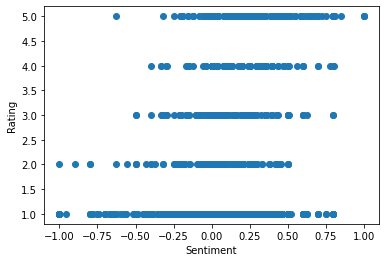

In [18]:
# See chart
import matplotlib.pyplot as plt
from importlib import reload

TOPIC_NAME = "fee"

plt = reload(plt)
x = reviews_df[reviews_df["topic"] == TOPIC_NAME]["sent_pol"] #! When you don't use loc you get a series
y = reviews_df[reviews_df["topic"] == TOPIC_NAME]["rating"]

plt.scatter(x, y)
plt.xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
plt.ylabel("Rating")


In [19]:
# Create the model and display fit
from sklearn import linear_model
model = linear_model.LinearRegression()
x = reviews_df.loc[reviews_df["topic"] == TOPIC_NAME].loc[:, ["sent_pol"]]
model.fit(x, y)
model.score(x, y)

0.11507778991301398

In [20]:
topic_dict = {
    "app" : "App/UI/Features",
    "fee" : "Fees",
    "transaction" : "Deposit/Withdrawals/Transaction Handling",
    "verification" : "Registration/Verification Process",
    "service" : "Customer Service",
    "trust" : "Trust and Company Reputation",
    "N": "Ignore this"
}

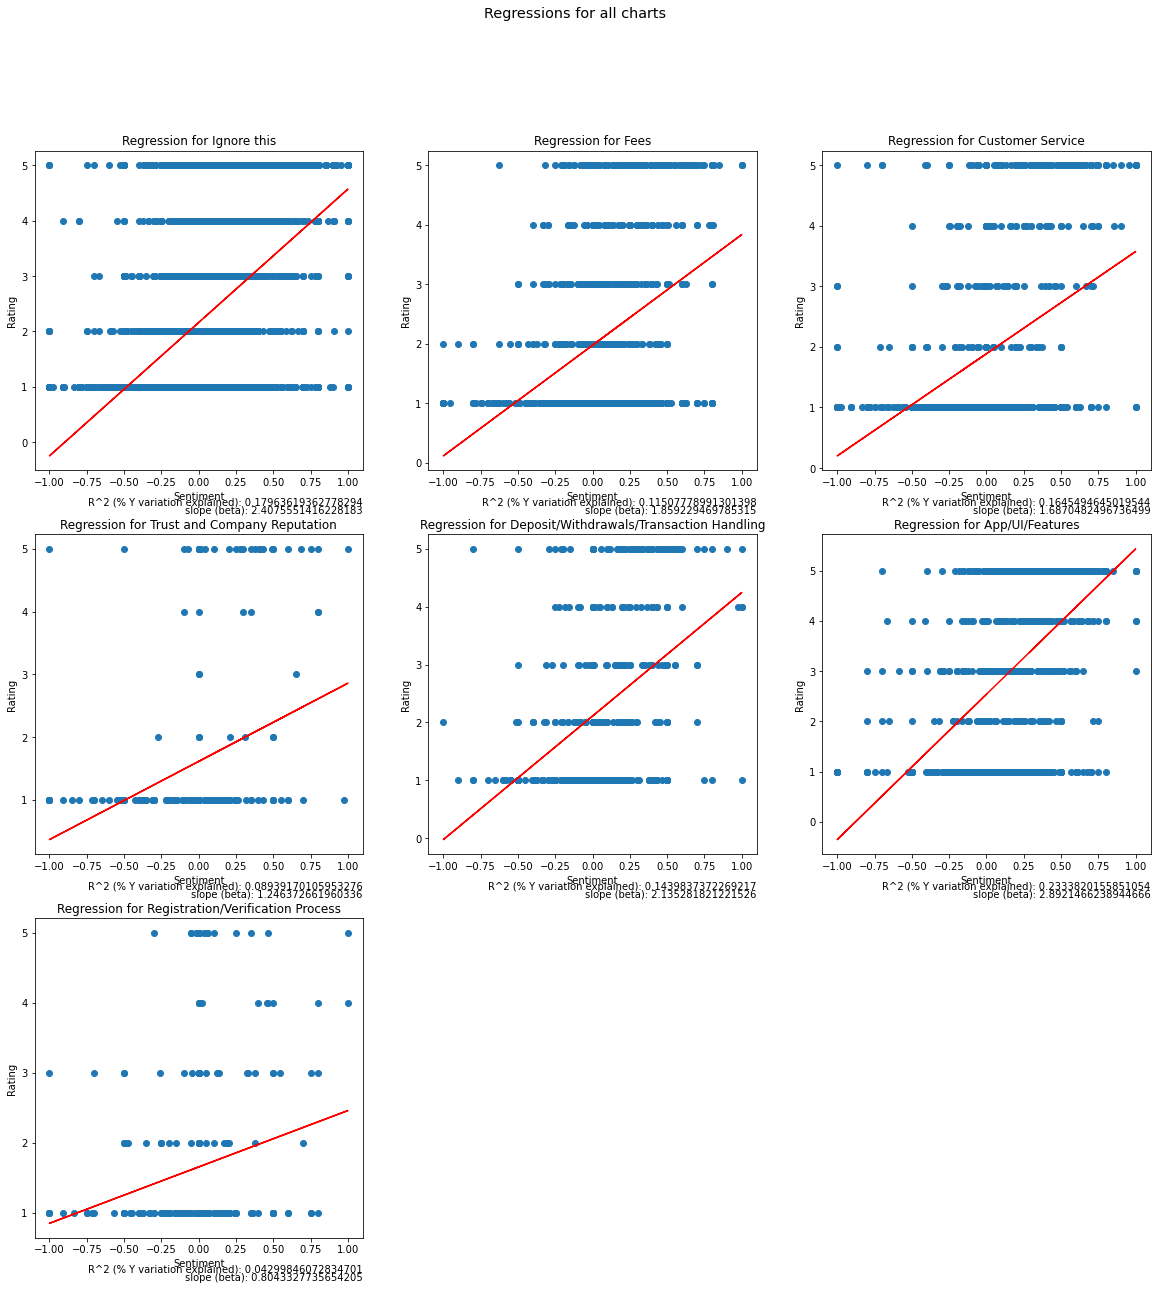

In [21]:
# Now we plot for all the topic
fig = plt.figure(figsize=(20,20))
st = fig.suptitle("Regressions for all charts", fontsize="x-large")

idx = 1
for key in reviews_df["topic"].unique():
    y = reviews_df[reviews_df["topic"] == key]["rating"]
    x = reviews_df.loc[reviews_df["topic"] == key].loc[:, ["sent_pol"]]
    model.fit(x, y)
    score = model.score(x, y)
    x = reviews_df[reviews_df["topic"] == key]["sent_pol"]
    curr_plot = fig.add_subplot(3, 3, idx)
    curr_plot.scatter(x, y)
    curr_plot.set_title(f"Regression for {topic_dict[key]}")
    curr_plot.set_xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
    curr_plot.set_ylabel("Rating")
    curr_plot.plot(x, model.coef_*x + model.intercept_, "r") 
    curr_plot.annotate(f"slope (beta): {model.coef_[0]}",
            xy = (1.0, -0.125),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
    curr_plot.annotate(f"R^2 (% Y variation explained): {score}",
            xy = (1.0, -0.1),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

    idx = idx + 1

fig.show()

In [22]:
reviews_df.to_csv("sent_crypto_bow.csv")